# Esplanade dataset
readme

In [2]:
%matplotlib widget

import os
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality

from cedalion.sigdecomp.ERBM import ERBM

import xarray as xr
import matplotlib.pyplot as p
import cedalion.plots as plots
from cedalion import units
import numpy as np
import pandas as pd
from math import ceil

import gzip
import pickle


# import my own functions from a different directory
import sys
sys.path.append('/Users/dboas/Documents/GitHub/cedalion-dab-funcs')
import DABfuncs_load_and_preprocess as pfDAB
import DABfuncs_plot_DQR as pfDAB_dqr
import DABfuncs_group_avg as pfDAB_grp_avg
import DABfuncs_ERBM_ICA as pfDAB_ERBM

# Turn off all warnings
import warnings
warnings.filterwarnings('ignore')

In [84]:
import importlib
importlib.reload(pfDAB_grp_avg)
importlib.reload(pfDAB_dqr)

<module 'DABfuncs_plot_DQR' from '/Users/dboas/Documents/GitHub/cedalion-dab-funcs/DABfuncs_plot_DQR.py'>

# Initialize root directory, files and parameters

In [ ]:
# root directory for the BIDS dataset
rootDir_data = '/Users/dboas/Documents/People/2024/BoasDavid/NN22_Data/Datasets/Esplanade/'

# subject and file IDs to process
subj_ids = ['01','02','03','04','05','06','07','08','09']
file_ids = ['IWHD_run-01']

# list of stim trial_types to include...
stim_lst_dqr = ['ST'] # for DQR plots
stim_lst_hrf = ['ST'] # for calculating HRFs

# pruning parameters
snr_thresh = 5 # the SNR (std/mean) of a channel. 
sd_threshs = [1, 60]*units.mm # defines the lower and upper bounds for the source-detector separation that we would like to keep
amp_threshs = [1e-5, 0.89] # define whether a channel's amplitude is within a certain range

# motion correction parameters
flag_do_splineSG = False # if True, will do splineSG motion correction

# band pass filter parameters applied to OD after motion correction
fmin = 0.02 * units.Hz
fmax = 3 * units.Hz





# determine the number of subjects and files. Often used in loops.
n_subjects = len(subj_ids)
n_files_per_subject = len(file_ids)

# Load and Pre-Process

Loading 1 of 9 subjects, 1 of 1 files : sub-01_task-IWHD_run-01_nirs
Loading 2 of 9 subjects, 1 of 1 files : sub-02_task-IWHD_run-01_nirs
Loading 3 of 9 subjects, 1 of 1 files : sub-03_task-IWHD_run-01_nirs
Loading 4 of 9 subjects, 1 of 1 files : sub-04_task-IWHD_run-01_nirs
Loading 5 of 9 subjects, 1 of 1 files : sub-05_task-IWHD_run-01_nirs
Loading 6 of 9 subjects, 1 of 1 files : sub-06_task-IWHD_run-01_nirs
Loading 7 of 9 subjects, 1 of 1 files : sub-07_task-IWHD_run-01_nirs
Loading 8 of 9 subjects, 1 of 1 files : sub-08_task-IWHD_run-01_nirs
Loading 9 of 9 subjects, 1 of 1 files : sub-09_task-IWHD_run-01_nirs


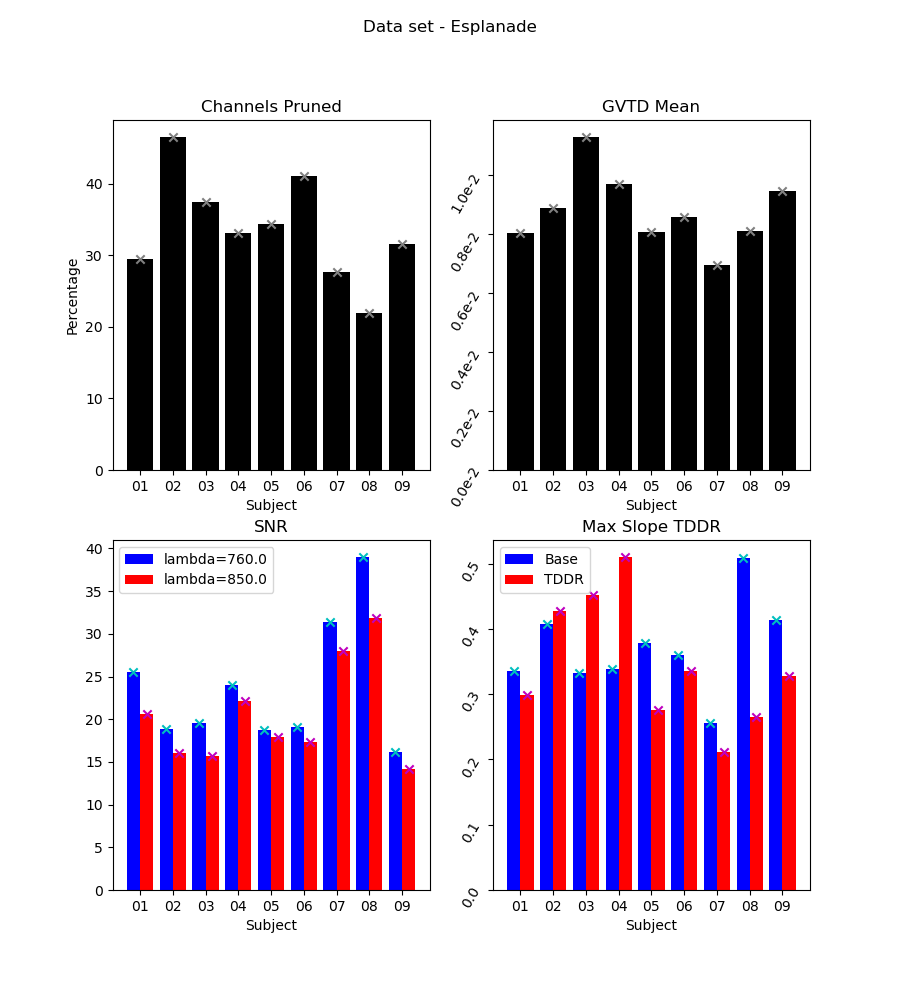

In [5]:
# Load and preprocess the data
#
# This function will load all the data for the specified subject and file IDs, and preprocess the data.
# This function will also create several data quality report (DQR) figures that are saved in /derivatives/plots.
# The function will return the preprocessed data and a list of the filenames that were loaded, both as 
# two dimensional lists [subj_idx][file_idx].
# The data is returned as a recording container with the following fields:
#   timeseries - the data matrices with dimensions of ('channel', 'wavelength', 'time') 
#      or ('channel', 'HbO/HbR', 'time') depending on the data type. 
#      The following sub-fields are included:
#         'amp' - the original amplitude data slightly processed to remove negative and NaN values and to 
#            apply a 3 point median filter to remove outliers.
#         'amp_pruned' - the 'amp' data pruned according to the SNR, SD, and amplitude thresholds.
#         'od' - the optical density data
#         'od_tddr' - the optical density data after TDDR motion correction is applied
#         'conc_tddr' - the concentration data obtained from 'od_tddr'
#         'od_splineSG' and 'conc_splineSG' - returned if splineSG motion correction is applied (i.e. flag_do_splineSG=True)
#   stim - the stimulus data with 'onset', 'duration', and 'trial_type' fields and more from the events.tsv files.
#   aux_ts - the auxiliary time series data from the SNIRF files.
#      In addition, the following aux sub-fields are added during pre-processing:
#         'gvtd' - the global variance of the time derivative of the 'od' data.
#         'gvtd_tddr' - the global variance of the time derivative of the 'od_tddr' data.

rec, filenm_lst = pfDAB.load_and_preprocess( rootDir_data, subj_ids, file_ids, snr_thresh, sd_threshs, amp_threshs, stim_lst_dqr, flag_do_splineSG, fmin, fmax )

## Produce tIncCh motion artifact DQR
This is optional. It shows the number of motion artifacts identifed per channel after TDDR on a scalp plot. It also shows the fraction of channels that have a motion artifact versus time and stores this in rec.aux_ts['tInc_all_tddr'] so you can view it with vis_time_series.py. It also plots the GVTD after TDDR so you can consider that along with tInc_all when identify time periods to mask.

You can re-run this after doing the ERBM ICA filter below and it will also plot the tIncCh results for 'od_tddr_ica'

In [85]:
rec = pfDAB_dqr.plot_tIncCh_dqr( rec, rootDir_data, filenm_lst )

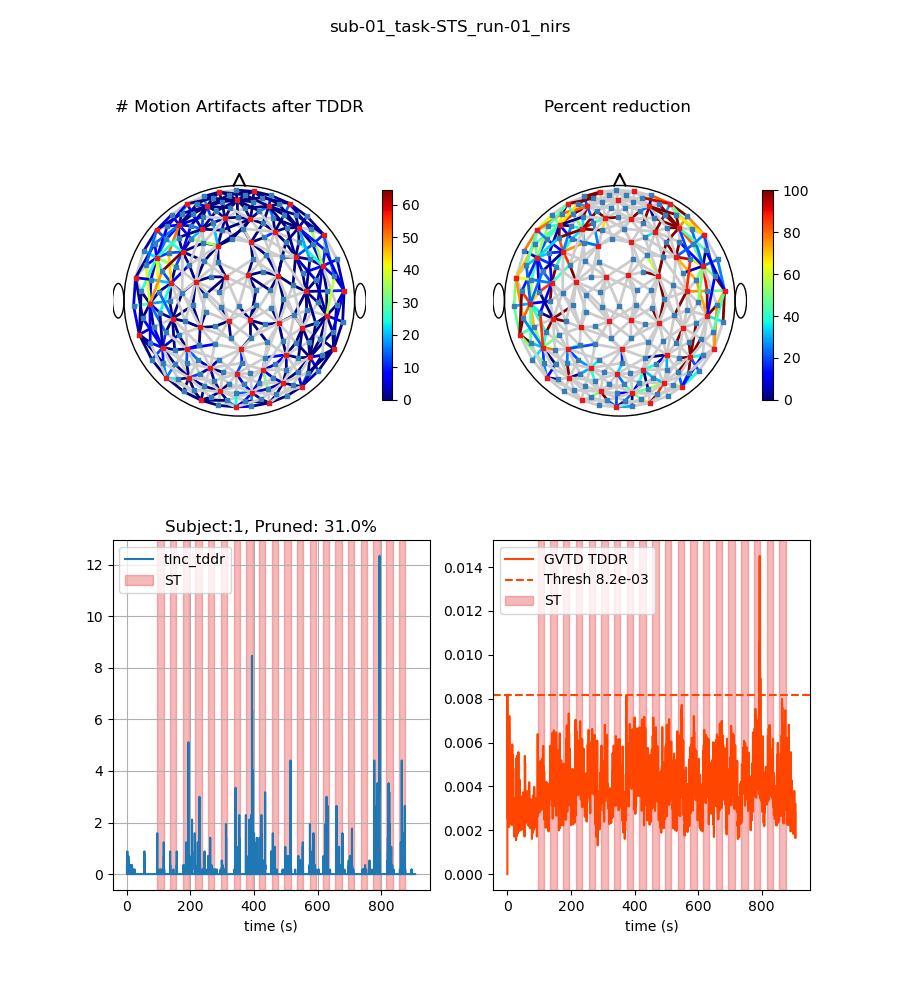

[[<Recording |  timeseries: ['amp', 'amp_pruned', 'od', 'od_tddr', 'conc_tddr'],  masks: [],  stim: ['ST'],  aux_ts: ['digital', 'analog-1', 'analog-2', 'dark signal', 'temparature', 'gyroscope', 'accelerometer', 'gvtd', 'gvtd_tddr', 'tInc_all_tddr'],  aux_obj: []>]]

In [14]:
# show result for a specific subject and file with plot_flag=True
# and try different igr thresholds
subj_idx = 0
file_idx = 0

iqr_threshold_std = 8 # default is 2
iqr_threshold_grad = 6 # default is 1.5

foo = []
foo.append( [rec[subj_idx][file_idx]] )
pfDAB_dqr.plot_tIncCh_dqr( foo, rootDir_data, filenm_lst, iqr_threshold_std, iqr_threshold_grad, flag_plot=True )


In [41]:
sci_threshold = 0.6
psp_threshold = 0.1
window_length = 5 * units.s

#recTmp, chs_pruned, sci, psp = pfDAB.pruneChannels( rec[0][0], snr_thresh, sd_threshs, amp_threshs )
sci, sci_mask = quality.sci(rec[0][0]['od_tddr'], window_length, sci_threshold)


In [42]:
sci

<xarray.DataArray (channel: 567, time: 182)> Size: 826kB
array([[       inf, 0.8717457 , 0.90516439, ..., 0.91702764, 0.93520568,
        0.93416875],
       [       inf, 0.95016921, 0.87966002, ..., 0.95279938, 0.85676666,
        0.97408364],
       [       inf, 0.92756212, 0.89921181, ..., 0.90100116, 0.93861445,
        0.94416826],
       ...,
       [       inf, 0.99836133, 0.99873496, ..., 0.99951614, 0.99785458,
        0.99740688],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [       inf, 0.9553044 , 0.90777097, ..., 0.94780758, 0.92181437,
        0.96015262]])
Coordinates:
  * time      (time) float64 1kB 0.0 5.006 10.01 15.02 ... 896.1 901.1 906.1
    samples   (time) int64 1kB 0 45 90 135 180 225 ... 7965 8010 8055 8100 8145
  * channel   (channel) object 5kB 'S10D87' 'S10D94' ... 'S47D29' 'S5D137'
    source    (channel) object 5kB 'S10' 'S10' 'S10' 'S10' ... 'S56' 'S47' 'S5'
    detector  (channel) object 5kB 'D87' 'D94' 'D89' ... 'D129' 'D29' 'D137'

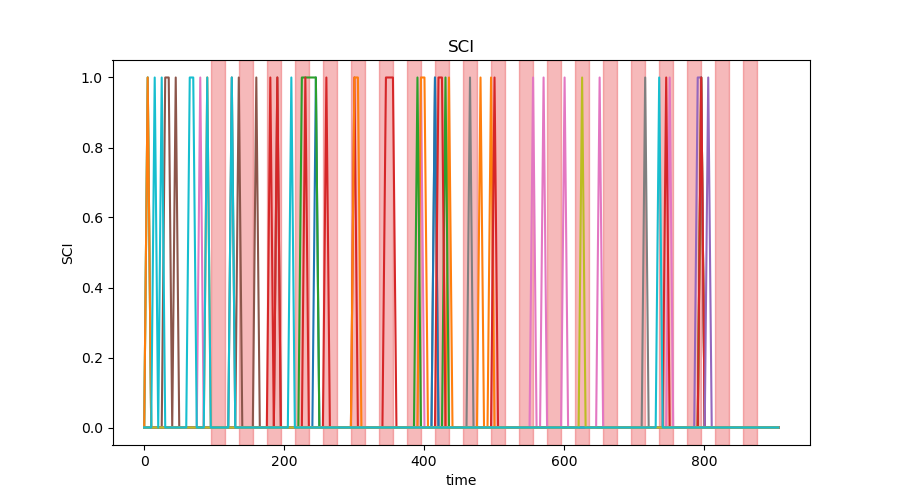

In [43]:
# find the good channels
lst_good_chs_indices = [i for i in range(len(chs_pruned)) if chs_pruned[i] == 0.4 and np.min(sci[i,:]) < 0.]

# plot sci
f,ax = p.subplots(1,1,figsize=(9,5))
ax.plot(sci.time, sci[lst_good_chs_indices,:].transpose()<0)
plots.plot_stim_markers(ax, rec[subj_idx][file_idx].stim, y=1)

ax.set_xlabel('time')
ax.set_ylabel('SCI')
ax.set_title('SCI')
p.show()



## Save one run to a pickle file for viewing with vis_time_series.py

In [49]:
# Save the rec object to a pickle file so you can view it with vis_time_series.py
# save one file from one subject at a time.
# this is saved in the derivatives/processed_data directory.
subj_idx = 4
file_idx = 0

print(f'Saving sub-{subj_ids[subj_idx]}_{file_ids[file_idx]} to pickle file')


file_path_pkl = os.path.join(rootDir_data, 'derivatives', 'processed_data', 'rec.pkl.gz')
file = gzip.GzipFile(file_path_pkl, 'wb')
file.write(pickle.dumps(rec[subj_idx][file_idx]))
file.close()     

Saving 05_IWHD_run-01 to pickle file


# ERBM

## save the ICA matrices

In [64]:
# If you already saved the ICA matrices and did not change the preprocessing in any way, then you can skip
# this step and go directly to the next step.

pca_var_thresh = 0.99 # keep enough PCs to explain this fraction of the variance
p_ica = 27 # not sure what this does

ica_lpf = 1.0 * units.Hz # low pass filter the data before ICA
ica_downsample = 1  # downsample the data by this factor before running ICA. ICA cost is linear with number of samples.
                    # and since we low pass filtered the data before ICA, we can downsample it to save time.
                    # Note that the NN22 sample rate is often ~9 Hz, and will be reduced by this factor.

for subj_idx in range( n_subjects ):
    for file_idx in range(n_files_per_subject):
        
        filenm = filenm_lst[subj_idx][file_idx]
        print( f'Processing {filenm}' )

        # the TS data to get the ICA of. 
        foo = rec[subj_idx][file_idx]["od_tddr"].copy()
        foo = cedalion.sigproc.frequency.freq_filter(foo, 0 * units.Hz, ica_lpf )
        # downsample foo by ica_downsample
        foo = foo[:,:,::ica_downsample]
        TS = foo.stack(measurement = ['channel', 'wavelength']).sortby('wavelength')

        # PCA step
        S_pca_thresh, W_pca, num_components = pfDAB_ERBM.ERBM_pca_step( TS, pca_var_thresh )
        print(f'   number of PCA components kept: {num_components}')
    
        # ICA-ERBM on PCs
        import time
        from datetime import datetime
        start_time = time.time()
        print(f'   start time = {datetime.fromtimestamp(start_time).strftime("%Y-%m-%d %H:%M:%S")}')
        W_ica = ERBM(S_pca_thresh.T, p_ica)
        end_time = time.time()
        execution_time = end_time - start_time
        print( f"   ERBM ICA execution time: {execution_time/60:0.1f} minutes")
    
        # Save W_ica to a file
        file_path = os.path.join(rootDir_data, 'derivatives', 'ica', filenm )
        np.savez(file_path + f'_Wica_od_tddr_ds{ica_downsample}.npz', W_ica=W_ica )

Processing sub-01_task-IWHD_run-01_nirs
   number of PCA components kept: 198
   start time = 2025-01-01 19:39:13
   ERBM ICA execution time: 28.0 minutes
Processing sub-02_task-IWHD_run-01_nirs
   number of PCA components kept: 191
   start time = 2025-01-01 20:07:15
   ERBM ICA execution time: 54.4 minutes
Processing sub-03_task-IWHD_run-01_nirs
   number of PCA components kept: 161
   start time = 2025-01-01 21:01:41
   ERBM ICA execution time: 132.9 minutes
Processing sub-04_task-IWHD_run-01_nirs
   number of PCA components kept: 211
   start time = 2025-01-01 23:14:38
   ERBM ICA execution time: 40.1 minutes
Processing sub-05_task-IWHD_run-01_nirs
   number of PCA components kept: 168
   start time = 2025-01-01 23:54:46
   ERBM ICA execution time: 136.0 minutes
Processing sub-06_task-IWHD_run-01_nirs
   number of PCA components kept: 177
   start time = 2025-01-02 02:10:46
   ERBM ICA execution time: 54.7 minutes
Processing sub-07_task-IWHD_run-01_nirs
   number of PCA components 

## ERBM filtering step

In [86]:
pca_var_thresh = 0.99 # MUST be the same as used when creating W_ica
p_ica = 27  # MUST be the same as used when creating W_ica

ica_lpf = 1.0 * units.Hz # MUST be the same as used when creating W_ica
ica_downsample = 3 # MUST be the same as used when creating W_ica

# used for helping determine which ICA components to keep and remove
trange_hrf = [5, 35] * units.s # time range for block averaging
trange_hrf_stat = [5, 20] # time range for t-stat
stim_lst_hrf_ica = ['ST','DT'] # which trial_types to consider for which ICA components to keep

ica_spatial_mask_thresh = 1.0 # for selecting "etCO2" components to remove
ica_tstat_thresh = 1.0 # for selecting significant components to keep


for subj_idx in range( n_subjects ):
    for file_idx in range(n_files_per_subject):

        filenm = filenm_lst[subj_idx][file_idx]
        print(f'Processing {filenm}')

        # the TS data to get the ICA of.
        # MUST BE THE SAME AS THE DATA USED TO GET W_ica
        foo = rec[subj_idx][file_idx]["od_tddr"].copy()
        foo = cedalion.sigproc.frequency.freq_filter(foo, 0 * units.Hz, ica_lpf )
        # downsample foo by ica_downsample
        foo = foo[:, :, ::ica_downsample]
        TS = foo.stack(measurement=['channel', 'wavelength']).sortby('wavelength')

        # PCA step
        S_pca_thresh, W_pca, num_components = pfDAB_ERBM.ERBM_pca_step(TS, pca_var_thresh)
        print(f'   number of PCA components kept: {num_components}')

        # load W_ica from file
        file_path = os.path.join(rootDir_data, 'derivatives', 'ica', filenm)
        # W_ica = np.load(file_path + '_Wica_od_tddr.npz')['W_ica']
        W_ica = np.load(file_path + f'_Wica_od_tddr_ds{ica_downsample}.npz')['W_ica']

        # project to ICA space
        S_ica = W_ica @ S_pca_thresh.T

        # do the ICA filter
        stim = rec[subj_idx][file_idx].stim.copy()
        rec[subj_idx][file_idx]['od_tddr_ica'], num_components_sig_ica, num_components_remove, num_components_sig_minus_remove = pfDAB_ERBM.ERBM_ica_step(
            TS, stim, W_pca, W_ica, S_ica, trange_hrf, trange_hrf_stat, ica_spatial_mask_thresh, ica_tstat_thresh, stim_lst_hrf_ica
        )
        print(f'   number of significant ICA components: {num_components_sig_ica}')
        print(f'   number of ICA components identified by spatial mask: {num_components_remove}')
        print(f'   number of significant ICA components removed: {num_components_sig_ica-num_components_sig_minus_remove}')
        print(f'   number of ICA components kept: {num_components_sig_minus_remove}')

        # convert to concentration
        dpf = xr.DataArray(
            [1, 1],
            dims="wavelength",
            coords={"wavelength": rec[subj_idx][file_idx]['amp'].wavelength},
        )
        rec[subj_idx][file_idx]['conc_tddr_ica'] = cedalion.nirs.od2conc(rec[subj_idx][file_idx]['od_tddr_ica'], rec[subj_idx][file_idx].geo3d, dpf, spectrum="prahl")



Processing sub-01_task-IWHD_run-01_nirs
   number of PCA components kept: 198
   number of significant ICA components: 156
   number of ICA components identified by spatial mask: 56
   number of significant ICA components removed: 47
   number of ICA components kept: 109
Processing sub-02_task-IWHD_run-01_nirs
   number of PCA components kept: 191
   number of significant ICA components: 148
   number of ICA components identified by spatial mask: 39
   number of significant ICA components removed: 33
   number of ICA components kept: 115
Processing sub-03_task-IWHD_run-01_nirs
   number of PCA components kept: 161
   number of significant ICA components: 117
   number of ICA components identified by spatial mask: 41
   number of significant ICA components removed: 32
   number of ICA components kept: 85
Processing sub-04_task-IWHD_run-01_nirs
   number of PCA components kept: 211
   number of significant ICA components: 163
   number of ICA components identified by spatial mask: 60
   

# HRF group average

## GLM with SSR

In [88]:
trange_hrf = [5, 35] * units.s # time range for block averaging
trange_hrf_stat = [5, 20] # time range for t-stat

stim_lst_hrf = ['ST','DT'] # for calculating HRFs

# this is utilized in the block average function if you do GLM analysis
ssr_rho_thresh = 15 * units.mm
glm_basis_func_param = 1 * units.s
glm_drift_order = 4

flag_save_each_subj = False # if True, will save the block average data for each subject
flag_do_GLM = False # if True, will do GLM analysis, otherwise does block average
                    # The GLM doesn't presently handle any NaN's it seems. But 
                    # pruned channels have NaN's.. curious.

subj_id_exclude = ['05','07'] # if you want to exclude a subject from the group average


blockaverage_subj = None

# loop over subjects and files
for subj_idx in range( n_subjects ):
    for file_idx in range( n_files_per_subject ):

        filenm = filenm_lst[subj_idx][file_idx]

        print( f"Running {subj_idx+1} of {n_subjects} subjects : {filenm}" )

        if flag_do_splineSG:
            conc_filt = rec[subj_idx][file_idx]['conc_splineSG'].copy()
        else:
            conc_filt = rec[subj_idx][file_idx]['conc_tddr'].copy()
        # LPF the data to match the ICA data
        conc_filt = cedalion.sigproc.frequency.freq_filter(conc_filt, 0 * units.Hz, ica_lpf )

        # check if rec[subj_idx][file_idx]['conc_tddr_ica'] exists
        if 'conc_tddr_ica' in rec[subj_idx][file_idx].timeseries.keys():
            conc_filt_ica = rec[subj_idx][file_idx]['conc_tddr_ica'].copy()
        else:
            conc_filt_ica = None

        #
        # block average
        #

        # select the stim for the given file
        stim = rec[subj_idx][file_idx].stim.copy()

        # get the epochs
        conc_epochs_tmp = pfDAB_grp_avg.block_average( conc_filt, stim, rec[subj_idx][file_idx].geo3d, trange_hrf, glm_basis_func_param, glm_drift_order, flag_do_GLM, ssr_rho_thresh, stim_lst_hrf )
        # concatenate the different epochs from each file for each subject
        if file_idx == 0:
            conc_epochs_all = conc_epochs_tmp
        else:
            conc_epochs_all = xr.concat([conc_epochs_all, conc_epochs_tmp], dim='epoch')

        # get the epochs for ICA filtered data
        if conc_filt_ica is not None:
            stim_ica = rec[subj_idx][file_idx].stim.copy()
            stim_ica['trial_type'] = stim_ica['trial_type'] + '-ica'
            stim_lst_hrf_ica = [x + '-ica' for x in stim_lst_hrf]

            # get the epochs for ICA filtered data
            conc_epochs_ica_tmp = pfDAB_grp_avg.block_average( conc_filt_ica, stim_ica, rec[subj_idx][file_idx].geo3d, trange_hrf, glm_basis_func_param, glm_drift_order, flag_do_GLM, ssr_rho_thresh, stim_lst_hrf_ica )
            # interpolate the ICA epochs to the same time points as the non-ICA epochs
            conc_epochs_ica_tmp = conc_epochs_ica_tmp.interp(reltime=conc_epochs_all.reltime) * units.micromolar
            # concatenate the different epochs from each file for each subject
            conc_epochs_all = xr.concat([conc_epochs_all, conc_epochs_ica_tmp], dim='epoch')

        if flag_save_each_subj:
            conc_epochs_tmp = conc_epochs_tmp.assign_coords(trial_type=('epoch', [x + '-' + subj_ids[subj_idx] for x in conc_epochs_tmp.trial_type.values]))
            conc_epochs_ica_tmp = conc_epochs_ica_tmp.assign_coords(trial_type=('epoch', [x + '-' + subj_ids[subj_idx] for x in conc_epochs_ica_tmp.trial_type.values]))

            conc_epochs_all = xr.concat([conc_epochs_all, conc_epochs_tmp], dim='epoch')
            conc_epochs_all = xr.concat([conc_epochs_all, conc_epochs_ica_tmp], dim='epoch')

        # DONE LOOP OVER FILES

    # Block Average
    baseline_conc = conc_epochs_all.sel(reltime=(conc_epochs_all.reltime < 0)).mean('reltime')
    conc_epochs = conc_epochs_all - baseline_conc
    blockaverage = conc_epochs.groupby('trial_type').mean('epoch')

    # gather the blockaverage across subjects
    if blockaverage_subj is None and subj_ids[subj_idx] not in subj_id_exclude:
        # blockaverage_subj = np.zeros((blockaverage.values.shape[0], blockaverage.values.shape[1], blockaverage.values.shape[2], blockaverage.values.shape[3], n_subjects)) 
        # blockaverage_subj[:,:,:,:,0] = blockaverage
        blockaverage_subj = blockaverage
        # add a subject dimension and coordinate
        blockaverage_subj = blockaverage_subj.expand_dims('subj')
        blockaverage_subj = blockaverage_subj.assign_coords(subj=[subj_ids[subj_idx]])
    elif subj_ids[subj_idx] not in subj_id_exclude:
        # blockaverage_subj[:,:,:,:,subj_idx] = blockaverage
        blockaverage_subj_tmp = blockaverage
        blockaverage_subj_tmp = blockaverage_subj_tmp.expand_dims('subj')
        blockaverage_subj_tmp = blockaverage_subj_tmp.assign_coords(subj=[subj_ids[subj_idx]])
        blockaverage_subj = xr.concat([blockaverage_subj, blockaverage_subj_tmp], dim='subj')
    else:
        print(f"   Subject {subj_ids[subj_idx]} excluded from group average")

    # DONE LOOP OVER SUBJECTS


# Save the block average data to a pickle file
# this can then be viewed with vis_plot_probe_from_pickle.py
# The file is saved in derivates/processed_data/blockaverage.pkl.gz
# blockaverage_subj_mean = np.nanmean(blockaverage_subj, axis=4)
# blockaverage.values = blockaverage_subj_mean
blockaverage = blockaverage_subj.mean('subj')
if flag_save_each_subj:
    # FIXME: this assumes the number of subjects and trial_type. Generalize this in the future.
    # blockaverage = blockaverage.sel(trial_type=['ST', 'ST-ica', 'ST-01', 'ST-ica-01', 'ST-02', 'ST-ica-02', 'ST-03', 'ST-ica-03', 'ST-04', 'ST-ica-04', 'ST-05', 'ST-ica-05', 'ST-06', 'ST-ica-06', 'ST-07', 'ST-ica-07', 'ST-08', 'ST-ica-08', 'ST-09', 'ST-ica-09'])
    blockaverage = blockaverage.sel(trial_type=['ST', 'ST-ica', 'ST-01', 'ST-ica-01', 'ST-02', 'ST-ica-02', 'ST-03', 'ST-ica-03', 'ST-04', 'ST-ica-04', 'ST-06', 'ST-ica-06', 'ST-08', 'ST-ica-08', 'ST-09', 'ST-ica-09'])
file_path_pkl = os.path.join(rootDir_data, 'derivatives', 'processed_data', 'blockaverage.pkl.gz')
file = gzip.GzipFile(file_path_pkl, 'wb')
file.write(pickle.dumps([blockaverage, rec[subj_idx][file_idx].geo2d, rec[subj_idx][file_idx].geo3d]))
file.close()     

print('Saved group average HRF to ' + file_path_pkl)



Running 1 of 9 subjects : sub-01_task-IWHD_run-01_nirs
Running 2 of 9 subjects : sub-02_task-IWHD_run-01_nirs
Running 3 of 9 subjects : sub-03_task-IWHD_run-01_nirs
Running 4 of 9 subjects : sub-04_task-IWHD_run-01_nirs
Running 5 of 9 subjects : sub-05_task-IWHD_run-01_nirs
   Subject 05 excluded from group average
Running 6 of 9 subjects : sub-06_task-IWHD_run-01_nirs
Running 7 of 9 subjects : sub-07_task-IWHD_run-01_nirs
   Subject 07 excluded from group average
Running 8 of 9 subjects : sub-08_task-IWHD_run-01_nirs
Running 9 of 9 subjects : sub-09_task-IWHD_run-01_nirs
Saved group average HRF to /Users/dboas/Documents/People/2024/BoasDavid/NN22_Data/Datasets/Esplanade/derivatives/processed_data/blockaverage.pkl.gz


## Scalp plot the group average

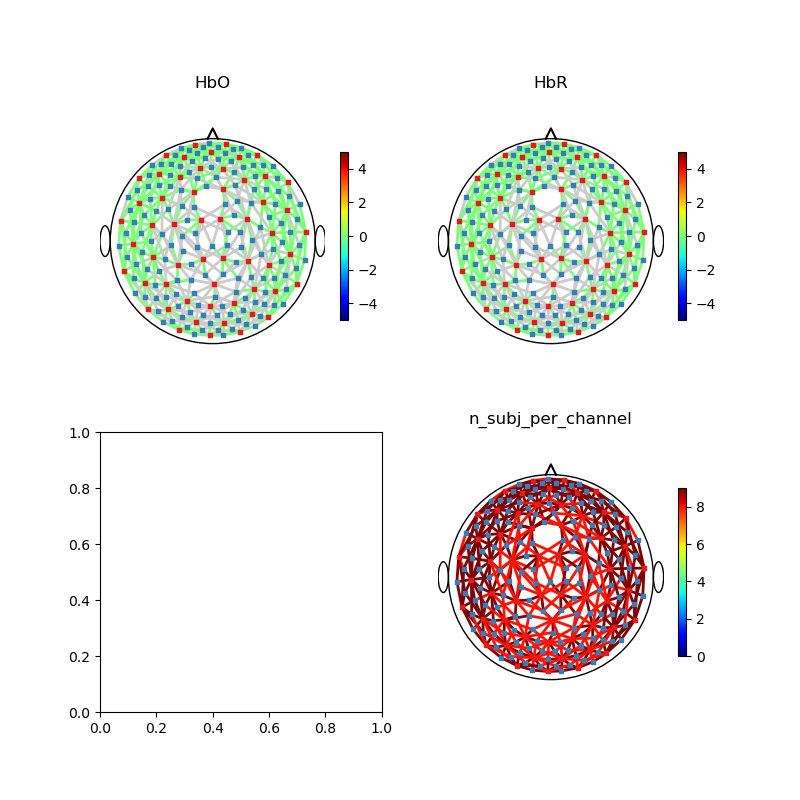

In [273]:
trial_str = ['ST-ica']

max_val = 5 

# save the average across subjects
blockaverage_subj_mean = np.nanmean(blockaverage_subj, axis=4)
blockaverage_subj_std = np.nanstd(blockaverage_subj, axis=4)

# how many columns have ~NaN
foo = np.squeeze(np.mean(blockaverage_subj[0,0,:,:,:], axis=1))
n_subj_per_channel = np.sum(~np.isnan(foo), axis=1)
n_subj_per_channel = n_subj_per_channel[:,np.newaxis] @ np.ones((1,blockaverage_subj_std.shape[0]))
n_subj_per_channel = n_subj_per_channel[:,:,np.newaxis] @ np.ones((1,blockaverage_subj_std.shape[1]))
n_subj_per_channel = n_subj_per_channel[:,:,:,np.newaxis] @ np.ones((1,blockaverage_subj_std.shape[3]))
n_subj_per_channel = n_subj_per_channel.transpose(1,2,0,3)
# put n_subj_per_channel into an xarray
n_subj_per_channel_xr = xr.DataArray(
    n_subj_per_channel,
    dims=["trial_type","chromo","channel", "reltime"],
    coords={"trial_type": blockaverage.trial_type, "chromo": blockaverage.chromo, "channel": blockaverage.channel, "reltime": blockaverage.reltime}
)

blockaverage_subj_tstat = blockaverage_subj_mean / (blockaverage_subj_std / np.sqrt(blockaverage_subj.shape[4]))

blockaverage_tstat = blockaverage.copy()
blockaverage_tstat.values = blockaverage_subj_tstat

# put the values of blockaverage_subj_mean into blockaverage2
blockaverage.values = blockaverage_subj_mean


# scalp plot the mean evoked response
f, ax = p.subplots(2, 2, figsize=(8, 8))

evoked_conc = blockaverage_tstat.sel(trial_type=trial_str, chromo='HbO', reltime=(blockaverage.reltime > trange_hrf_stat[0]) & (blockaverage.reltime < trange_hrf_stat[1])).mean("reltime")
# set values of evoked_conc to zero where the t-stat is less than 2
evoked_conc.values[np.abs(evoked_conc.values) < 2] = 0
plots.scalp_plot(
        rec[0][0]['conc_tddr'],
        rec[0][0].geo3d,
        evoked_conc,
        ax[0][0],
        cmap='jet',
        optode_labels=False,
        optode_size=5,
        vmin=-max_val,
        vmax=max_val,
        title='HbO'
    )

evoked_conc = blockaverage_tstat.sel(trial_type=trial_str, chromo='HbR', reltime=(blockaverage.reltime > trange_hrf_stat[0]) & (blockaverage.reltime < trange_hrf_stat[1])).mean("reltime")
# set values of evoked_conc to zero where the t-stat is less than 2
evoked_conc.values[np.abs(evoked_conc.values) < 2] = 0
plots.scalp_plot(
        rec[0][0]['conc_tddr'],
        rec[0][0].geo3d,
        evoked_conc,
        ax[0][1],
        cmap='jet',
        optode_labels=False,
        optode_size=5,
        vmin=-max_val,
        vmax=max_val,
        title='HbR'
    )

# scalp plot n_subj_per_channel
plots.scalp_plot(
        rec[0][0]['conc_tddr'],
        rec[0][0].geo3d,
        n_subj_per_channel_xr.sel(trial_type=trial_str,chromo='HbO', reltime=0),
        ax[1][1],
        cmap='jet',
        optode_labels=False,
        optode_size=5,
        vmin=0,
        vmax=n_subjects,
        title="n_subj_per_channel"
    )

